<a href="https://colab.research.google.com/github/spooozy/Machine-learning-methods/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats.mstats import winsorize
from copy import deepcopy

### Dataset

#### Dataset description

The dataset contains 45,000 records and 14 variables, each described below:

- `person_age`	- Age of the person	- Float

- `person_gender`	- Gender of the person	- Categorical

- `person_education` - 	Highest education level	- Categorical

- `person_income` - Annual income	- Float

- `person_emp_exp` -	Years of employment experience - Integer

- `person_home_ownership` -	Home ownership status (e.g., rent, own, mortgage) - 	Categorical

- `loan_amnt` -	Loan amount requested -	Float

- `loan_intent` -	Purpose of the loan -	Categorical

- `loan_int_rate` -	Loan interest rate -	Float

- `loan_percent_income` -	Loan amount as a percentage of annual income -	Float

- `cb_person_cred_hist_length` -	Length of credit history in years -	Float

- `credit_score` -	Credit score of the person - Integer

- `previous_loan_defaults_on_file` -	Indicator of previous loan defaults	- Categorical

- **`loan_status`** (target variable)	- Loan approval status: 1 = approved; 0 = rejected - Integer

In [ ]:
DATASET_PATH = 'loan_data.csv'
df = pd.read_csv(DATASET_PATH, sep=',')
df.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [ ]:
missing_stats = df.isnull().sum()
missing_stats

,0
person_age,0
person_gender,0
person_education,0
person_income,0
person_emp_exp,0
person_home_ownership,0
loan_amnt,0
loan_intent,0
loan_int_rate,0
loan_percent_income,0


#### Processing of gaps and outliers

In [ ]:
def analyze_outliers_percentage(df, numeric_columns):
    outlier_analysis = {}

    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = len(outliers)
        outlier_percentage = (outlier_count / len(df)) * 100

        outlier_analysis[col] = {
            'count': outlier_count,
            'percentage': outlier_percentage,
            'bounds': [lower_bound, upper_bound]
        }

    return outlier_analysis

In [ ]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
exclude_cols = ['loan_status']
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

outlier_report = analyze_outliers_percentage(df, numeric_cols)

print("Column outlier anaysis:")
print(f"{'Column':<30} {'Outlier':<10} {'%':<8}")

for col, stats in outlier_report.items():
    print(f"{col:<30} {stats['count']:<10} {stats['percentage']:<7.1f}")

Column outlier anaysis:
Column                         Outlier    %       
person_age                     2188       4.9    
person_income                  2218       4.9    
person_emp_exp                 1724       3.8    
loan_amnt                      2348       5.2    
loan_int_rate                  124        0.3    
loan_percent_income            744        1.7    
cb_person_cred_hist_length     1366       3.0    
credit_score                   467        1.0    


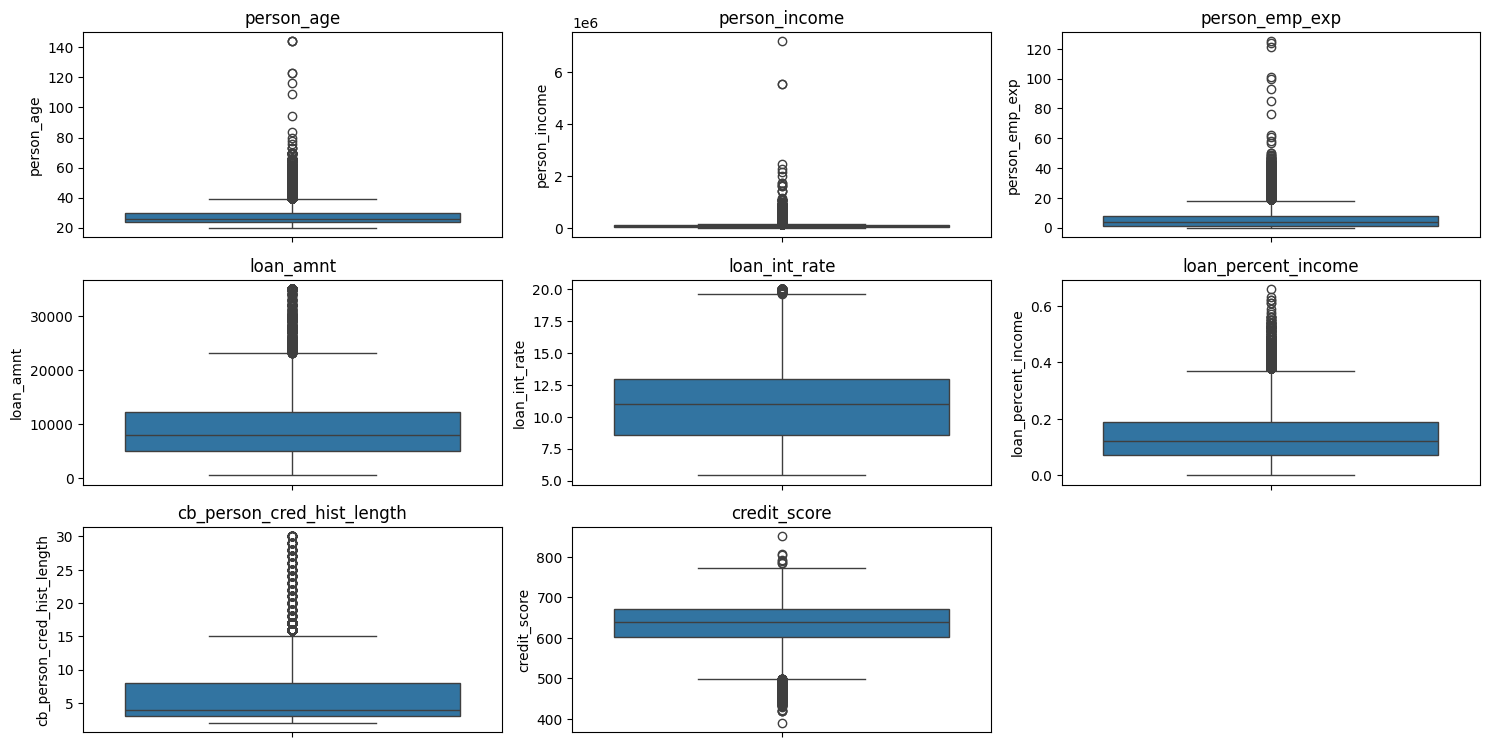

In [ ]:
plt.figure(figsize = (15, 10))
for i, col in enumerate(numeric_cols, 1):
  plt.subplot(4,3,i)
  sns.boxplot(y = df[col])
  plt.title(f"{col}")
plt.tight_layout()
plt.show()

In [ ]:
for col in numeric_cols:
  df[col] = winsorize(df[col], limits = [0.05, 0.05]).data

outlier_report = analyze_outliers_percentage(df, numeric_cols)

print("Column outlier anaysis:")
print(f"{'Column':<30} {'Outlier':<10} {'%':<8}")

for col, stats in outlier_report.items():
    print(f"{col:<30} {stats['count']:<10} {stats['percentage']:<7.1f}")

Column outlier anaysis:
Column                         Outlier    %       
person_age                     0          0.0    
person_income                  0          0.0    
person_emp_exp                 0          0.0    
loan_amnt                      2348       5.2    
loan_int_rate                  0          0.0    
loan_percent_income            0          0.0    
cb_person_cred_hist_length     0          0.0    
credit_score                   0          0.0    


#### Coding of categorical features



- `person_gender` - Label Encoding
- `person education` - Ordinal Encoding
- `previous_loan_defaults_on_file` - Label Encoding
- `person_home_ownership` - One-Hot Encoding
- `loan_intent` - One-Hot Encoding

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

# Label Encoding
df['person_gender'] = df['person_gender'].map({'female': 0, 'male': 1})
df['previous_loan_defaults_on_file'] = df['previous_loan_defaults_on_file'].map({'No': 0, 'Yes': 1})

# Ordinal Encoding
education_order = {'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5}
df['person_education'] = df['person_education'].map(education_order)

# One-Hot Enconding
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent'], prefix=['home', 'intent'], dtype=int)

df.head(5)


person_gender: ['female' 'male']
person_education: ['Master' 'High School' 'Bachelor' 'Associate' 'Doctorate']
person_home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
previous_loan_defaults_on_file: ['No' 'Yes']


,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,home_MORTGAGE,home_OTHER,home_OWN,home_RENT,intent_DEBTCONSOLIDATION,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE
0,22.0,0,4,71948.0,0,24000.0,16.00,0.31,3.0,561,...,0,0,0,1,0,0,0,0,1,0
1,22.0,0,1,28367.0,0,2000.0,11.14,0.08,2.0,539,...,0,0,1,0,0,1,0,0,0,0
2,25.0,0,1,28367.0,3,5500.0,12.87,0.31,3.0,635,...,1,0,0,0,0,0,0,1,0,0
3,23.0,0,3,79753.0,0,24000.0,15.23,0.31,2.0,675,...,0,0,0,1,0,0,0,1,0,0
4,24.0,1,4,66135.0,1,24000.0,14.27,0.31,4.0,586,...,0,0,0,1,0,0,0,1,0,0


#### Standartization

In [ ]:
from sklearn.preprocessing import StandardScaler

to_standartize = [
    'person_age',
    'person_education',
    'person_income',
    'person_emp_exp',
    'loan_amnt',
    'loan_int_rate',
    'cb_person_cred_hist_length',
    'credit_score'
]

scaler = StandardScaler()
df[to_standartize] = scaler.fit_transform(df[to_standartize])
df.head(5)

,person_age,person_gender,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,...,home_MORTGAGE,home_OTHER,home_OWN,home_RENT,intent_DEBTCONSOLIDATION,intent_EDUCATION,intent_HOMEIMPROVEMENT,intent_MEDICAL,intent_PERSONAL,intent_VENTURE
0,-1.118481,0,1.500068,-0.106043,-1.026337,2.455128,1.792355,0.31,-0.794462,-1.564522,...,0,0,0,1,0,0,0,0,1,0
1,-1.118481,0,-1.283563,-1.271863,-1.026337,-1.264998,0.063765,0.08,-1.085922,-2.040870,...,0,0,1,0,0,1,0,0,0,0
2,-0.505518,0,-1.283563,-1.271863,-0.423164,-0.673160,0.679086,0.31,-0.794462,0.037741,...,1,0,0,0,0,0,0,1,0,0
3,-0.914160,0,0.572191,0.102745,-1.026337,2.455128,1.518483,0.31,-1.085922,0.903829,...,0,0,0,1,0,0,0,1,0,0
4,-0.709839,1,1.500068,-0.261545,-0.825280,2.455128,1.177034,0.31,-0.503002,-1.023217,...,0,0,0,1,0,0,0,1,0,0


### Logistic regression

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train: (36000, 21), y_train: (36000,)
X_test: (9000, 21), y_test: (9000,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class LogisticRegression:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.loss_history = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def initialize_weights(self, n_features):
        return np.zeros((n_features, 1))

    def add_bias(self, X):
        return np.c_[np.ones((X.shape[0], 1)), X]

    def compute_loss(self, y, y_pred):
        m = y.shape[0]
        epsilon = 1e-8
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        loss = -1/m * np.sum(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        return loss

    def fit(self, X, y):
        X_with_bias = self.add_bias(X)
        y = y.reshape(-1, 1)
        n_features = X_with_bias.shape[1]
        self.weights = self.initialize_weights(n_features)
        self.loss_history = []
        for i in range(self.n_iterations):
            z = np.dot(X_with_bias, self.weights)
            y_pred = self.sigmoid(z)
            loss = self.compute_loss(y, y_pred)
            self.loss_history.append(loss)
            gradient = np.dot(X_with_bias.T, (y_pred - y)) / len(y)
            self.weights -= self.learning_rate * gradient
            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")

    def predict_proba(self, X):
        X_with_bias = self.add_bias(X)
        return self.sigmoid(np.dot(X_with_bias, self.weights))

    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return (probabilities > threshold).astype(int)

    def plot_loss(self):
        plt.figure(figsize=(6, 4))
        plt.plot(self.loss_history)
        plt.title('Loss function during training')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

Iteration 0, Loss: 0.6931
Iteration 100, Loss: 0.3457
Iteration 200, Loss: 0.3070
Iteration 300, Loss: 0.2885
Iteration 400, Loss: 0.2775
Iteration 500, Loss: 0.2701
Iteration 600, Loss: 0.2648
Iteration 700, Loss: 0.2609
Iteration 800, Loss: 0.2578
Iteration 900, Loss: 0.2554


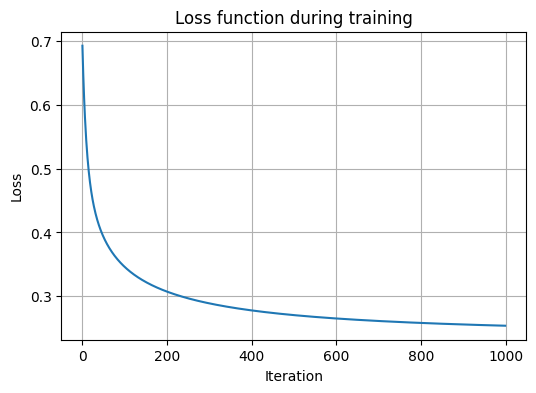

TP=1410, TN=6594, FP=406, FN=590
Accuracy: 0.8893
Precision: 0.7764
Recall: 0.7050
F: 0.7390


In [ ]:
model = LogisticRegression(learning_rate=0.1, n_iterations=1000)
model.fit(X_train.values, y_train.values)

model.plot_loss()

y_pred_proba = model.predict_proba(X_test.values)
y_pred = model.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = cm.ravel()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F: {f:.4f}")

### Support Vector Machine

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

y_train_svm = np.where(y_train_np == 0, -1, 1)
y_test_svm = np.where(y_test_np == 0, -1, 1)

X_train: (36000, 21), y_train: (36000,)
X_test: (9000, 21), y_test: (9000,)


In [ ]:
class SVM:
  def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
    self.lr = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters
    self.w = None
    self.b = 0
    self.loss_history = []

  def add_bias(self, X):
    return np.column_stack([np.ones(X.shape[0]), X])

  def fit(self, X, y):
    X_with_bias = self.add_bias(X)
    n_samples, n_features = X_with_bias.shape
    self.w = np.zeros(n_features)
    for iteration in range(self.n_iters):
      total_loss = 0
      for i in range(n_samples):
        margin = y[i] * np.dot(X_with_bias[i], self.w)
        if margin >= 1:
          self.w -= self.lr * (2 * self.lambda_param * self.w)
        else:
          self.w -= self.lr * (2 * self.lambda_param * self.w - y[i] * X_with_bias[i])
          total_loss += 1 - margin
      loss = total_loss / n_samples + self.lambda_param * np.sum(self.w ** 2)
      self.loss_history.append(loss)
      if iteration % 100 == 0:
       print(f"Iteration {iteration}, Loss: {loss:.4f}")

  def predict(self, X):
    X_with_bias = self.add_bias(X)
    linear_output = np.dot(X_with_bias, self.w)
    return np.sign(linear_output).astype(int)

  def plot_loss(self):
    plt.figure(figsize=(8, 6))
    plt.plot(self.loss_history)
    plt.title('Hingle Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

Iteration 0, Loss: 0.3672
Iteration 100, Loss: 0.3300
Iteration 200, Loss: 0.3300
Iteration 300, Loss: 0.3300
Iteration 400, Loss: 0.3300


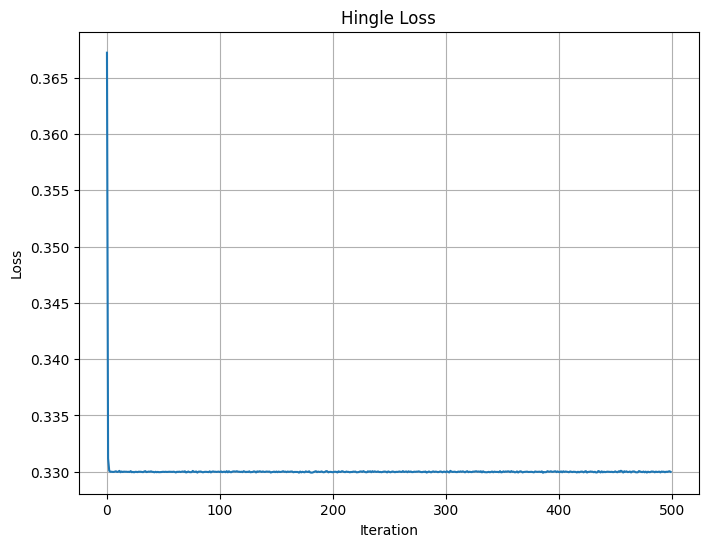

TP=1410, TN=6590, FP=410, FN=590
Accuracy: 0.8889
Precision: 0.7747
Recall: 0.7050
F: 0.7382


In [ ]:
svm = SVM(learning_rate=0.001, lambda_param=0.01, n_iters=500)
svm.fit(X_train_np, y_train_svm)
svm.plot_loss()
y_pred_svm = svm.predict(X_test_np)
y_pred_binary = np.where(y_pred_svm == -1, 0, 1)
accuracy = accuracy_score(y_test_np, y_pred_binary)
cm = confusion_matrix(y_test_np, y_pred_binary)

TN, FP, FN, TP = cm.ravel()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F: {f:.4f}")

In [ ]:
from sklearn.svm import LinearSVC

svm_sklearn = LinearSVC(max_iter=500, random_state=42)
svm_sklearn.fit(X_train_np, y_train_svm)

y_pred_sklearn = svm_sklearn.predict(X_test_np)
accuracy = accuracy_score(y_test_svm, y_pred_sklearn)
print(f"Sklearn SVM Accuracy: {accuracy:.4f}")

Sklearn SVM Accuracy: 0.8991


### CART

In [ ]:
class DecisionTreeCART:

    def __init__(self, max_depth=100, min_samples=2, ccp_alpha=0.0, regression=False):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.ccp_alpha = ccp_alpha
        self.regression = regression
        self.tree = None
        self._y_type = None
        self._num_all_samples = None

    def _set_df_type(self, X, y, dtype):
        X = X.astype(dtype)
        y = y.astype(dtype) if self.regression else y
        self._y_dtype = y.dtype

        return X, y

    @staticmethod
    def _purity(y):
        unique_classes = np.unique(y)

        return unique_classes.size == 1

    @staticmethod
    def _is_leaf_node(node):
        return not isinstance(node, dict)   # if a node/tree is a leaf

    def _leaf_node(self, y):
        class_index = 0

        return np.mean(y) if self.regression else y.mode()[class_index]

    def _split_df(self, X, y, feature, threshold):
        feature_values = X[feature]
        left_indexes = X[feature_values <= threshold].index
        right_indexes = X[feature_values > threshold].index
        sizes = np.array([left_indexes.size, right_indexes.size])

        return self._leaf_node(y) if any(sizes == 0) else left_indexes, right_indexes

    @staticmethod
    def _gini_impurity(y):
        _, counts_classes = np.unique(y, return_counts=True)
        squared_probabilities = np.square(counts_classes / y.size)
        gini_impurity = 1 - sum(squared_probabilities)

        return gini_impurity

    @staticmethod
    def _mse(y):
        mse = np.mean((y - y.mean()) ** 2)

        return mse

    @staticmethod
    def _cost_function(left_df, right_df, method):
        total_df_size = left_df.size + right_df.size
        p_left_df = left_df.size / total_df_size
        p_right_df = right_df.size / total_df_size
        J_left = method(left_df)
        J_right = method(right_df)
        J = p_left_df*J_left + p_right_df*J_right

        return J

    def _node_error_rate(self, y, method):
        if self._num_all_samples is None:
            self._num_all_samples = y.size
        current_num_samples = y.size

        return current_num_samples / self._num_all_samples * method(y)

    def _best_split(self, X, y):
        features = X.columns
        min_cost_function = np.inf
        best_feature, best_threshold = None, None
        method = self._mse if self.regression else self._gini_impurity

        for feature in features:
            unique_feature_values = np.unique(X[feature])

            for i in range(1, len(unique_feature_values)):
                current_value = unique_feature_values[i]
                previous_value = unique_feature_values[i-1]
                threshold = (current_value + previous_value) / 2
                left_indexes, right_indexes = self._split_df(X, y, feature, threshold)
                left_labels, right_labels = y.loc[left_indexes], y.loc[right_indexes]
                current_J = self._cost_function(left_labels, right_labels, method)

                if current_J <= min_cost_function:
                    min_cost_function = current_J
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _stopping_conditions(self, y, depth, n_samples):
        return self._purity(y), depth == self.max_depth, n_samples < self.min_samples

    def _grow_tree(self, X, y, depth=0):
        current_num_samples = y.size
        X, y = self._set_df_type(X, y, np.float128)
        method = self._gini_impurity

        if any(self._stopping_conditions(y, depth, current_num_samples)):
            RTi = self._node_error_rate(y, method)
            leaf_node = f'{self._leaf_node(y)} | error_rate {RTi}'
            return leaf_node

        Rt = self._node_error_rate(y, method)
        best_feature, best_threshold = self._best_split(X, y)
        decision_node = f'{best_feature} <= {best_threshold} | ' \
                        f'as_leaf {self._leaf_node(y)} error_rate {Rt}'

        left_indexes, right_indexes = self._split_df(X, y, best_feature, best_threshold)
        left_X, right_X = X.loc[left_indexes], X.loc[right_indexes]
        left_labels, right_labels = y.loc[left_indexes], y.loc[right_indexes]

        tree = {decision_node: []}
        left_subtree = self._grow_tree(left_X, left_labels, depth+1)
        right_subtree = self._grow_tree(right_X, right_labels, depth+1)

        if left_subtree == right_subtree:
            tree = left_subtree
        else:
            tree[decision_node].extend([left_subtree, right_subtree])

        return tree

    def _tree_error_rate_info(self, tree, error_rates_list):
        if self._is_leaf_node(tree):
            *_, leaf_error_rate = tree.split()
            error_rates_list.append(np.float128(leaf_error_rate))
        else:
            decision_node = next(iter(tree))
            left_subtree, right_subtree = tree[decision_node]
            self._tree_error_rate_info(left_subtree, error_rates_list)
            self._tree_error_rate_info(right_subtree, error_rates_list)

        RT = sum(error_rates_list)
        num_leaf_nodes = len(error_rates_list)

        return RT, num_leaf_nodes

    @staticmethod
    def _ccp_alpha_eff(decision_node_Rt, leaf_nodes_RTt, num_leafs):

        return (decision_node_Rt - leaf_nodes_RTt) / (num_leafs - 1)

    def _find_weakest_node(self, tree, weakest_node_info):
        if self._is_leaf_node(tree):
            return tree

        decision_node = next(iter(tree))
        left_subtree, right_subtree = tree[decision_node]
        *_, decision_node_error_rate = decision_node.split()

        Rt = np.float128(decision_node_error_rate)
        RTt, num_leaf_nodes = self._tree_error_rate_info(tree, [])
        ccp_alpha = self._ccp_alpha_eff(Rt, RTt, num_leaf_nodes)
        decision_node_index, min_ccp_alpha_index = 0, 1

        if ccp_alpha <= weakest_node_info[min_ccp_alpha_index]:
            weakest_node_info[decision_node_index] = decision_node
            weakest_node_info[min_ccp_alpha_index] = ccp_alpha

        self._find_weakest_node(left_subtree, weakest_node_info)
        self._find_weakest_node(right_subtree, weakest_node_info)

        return weakest_node_info

    def _prune_tree(self, tree, weakest_node):
        if self._is_leaf_node(tree):
            return tree

        decision_node = next(iter(tree))
        left_subtree, right_subtree = tree[decision_node]
        left_subtree_index, right_subtree_index = 0, 1
        _, leaf_node = weakest_node.split('as_leaf ')

        if weakest_node is decision_node:
            tree = weakest_node
        if weakest_node in left_subtree:
            tree[decision_node][left_subtree_index] = leaf_node
        if weakest_node in right_subtree:
            tree[decision_node][right_subtree_index] = leaf_node

        self._prune_tree(left_subtree, weakest_node)
        self._prune_tree(right_subtree, weakest_node)

        return tree

    def cost_complexity_pruning_path(self, X: pd.DataFrame, y: pd.Series):
        tree = self._grow_tree(X, y)   # grow a full tree
        tree_error_rate, _ = self._tree_error_rate_info(tree, [])
        error_rates = [tree_error_rate]
        ccp_alpha_list = [0.0]

        while not self._is_leaf_node(tree):
            initial_node = [None, np.inf]
            weakest_node, ccp_alpha = self._find_weakest_node(tree, initial_node)
            tree = self._prune_tree(tree, weakest_node)
            tree_error_rate, _ = self._tree_error_rate_info(tree, [])

            error_rates.append(tree_error_rate)
            ccp_alpha_list.append(ccp_alpha)

        return np.array(ccp_alpha_list), np.array(error_rates)

    def _ccp_tree_error_rate(self, tree_error_rate, num_leaf_nodes):

        return tree_error_rate + self.ccp_alpha*num_leaf_nodes

    def _optimal_tree(self, X, y):
        tree = self._grow_tree(X, y)
        min_RT_alpha, final_tree = np.inf, None

        while not self._is_leaf_node(tree):
            RT, num_leaf_nodes = self._tree_error_rate_info(tree, [])
            current_RT_alpha = self._ccp_tree_error_rate(RT, num_leaf_nodes)

            if current_RT_alpha <= min_RT_alpha:
                min_RT_alpha = current_RT_alpha
                final_tree = deepcopy(tree)

            initial_node = [None, np.inf]
            weakest_node, _ = self._find_weakest_node(tree, initial_node)
            tree = self._prune_tree(tree, weakest_node)

        return final_tree

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self.tree = self._optimal_tree(X, y)

    def _traverse_tree(self, sample, tree):
        if self._is_leaf_node(tree):
            leaf, *_ = tree.split()
            return leaf

        decision_node = next(iter(tree))  # dict key
        left_node, right_node = tree[decision_node]
        feature, other = decision_node.split(' <=')
        threshold, *_ = other.split()
        feature_value = sample[feature]

        if np.float128(feature_value) <= np.float128(threshold):
            next_node = self._traverse_tree(sample, left_node)
        else:
            next_node = self._traverse_tree(sample, right_node)

        return next_node

    def predict(self, samples: pd.DataFrame):
        results = samples.apply(self._traverse_tree, args=(self.tree,), axis=1)
        return np.array(results.astype(self._y_dtype))

In [ ]:
X = df.drop('loan_status', axis=1)
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values
y_test_np = y_test.values

X_train: (36000, 21), y_train: (36000,)
X_test: (9000, 21), y_test: (9000,)


In [ ]:
def cart_tree_plot(cart_tree, feature_names):
  def print_node(node, indent=""):
        if cart_tree._is_leaf_node(node):
            print(f"{indent} Node: {node}")
        else:
            decision_node = list(node.keys())[0]
            parts = decision_node.split(' | ')
            condition = parts[0]
            leaf_info = parts[1] if len(parts) > 1 else ""

            print(f"{indent} Condition: {condition}")
            print(f"{indent}     {leaf_info}")

            left_child, right_child = node[decision_node]
            print(f"{indent}     ├── Left subtree:")
            print_node(left_child, indent + "     │   ")
            print(f"{indent}     └── Right subtree:")
            print_node(right_child, indent + "        ")
  print_node(cart_tree.tree)

In [ ]:
tree = DecisionTreeCART(max_depth=5, min_samples=10, ccp_alpha=0.01)
tree.fit(X_train, y_train)

cart_tree_plot(tree, X_train)

predictions = tree.predict(X_test)
accuracy = accuracy_score(y_test_np, predictions)
cm = confusion_matrix(y_test_np, predictions)

TN, FP, FN, TP = cm.ravel()

precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F: {f:.4f}")

 Condition: previous_loan_defaults_on_file <= 0.5
     as_leaf 0 error_rate 0.345679012345679
     ├── Left subtree:
     │    Condition: loan_percent_income <= 0.245
     │        as_leaf 0 error_rate 0.24398463976746668
     │        ├── Left subtree:
     │        │    Condition: loan_int_rate <= 1.079222681885569
     │        │        as_leaf 0 error_rate 0.1782117332329152
     │        │        ├── Left subtree:
     │        │        │    Condition: person_income <= -1.2717965060756409
     │        │        │        as_leaf 0 error_rate 0.10746284566031188
     │        │        │        ├── Left subtree:
     │        │        │        │    Node: 1 error_rate 0.007353988603988605
     │        │        │        └── Right subtree:
     │        │        │            Node: 0 error_rate 0.08896733501237478
     │        │        └── Right subtree:
     │        │            Node: 1 error_rate 0.03560355079850493
     │        └── Right subtree:
     │            Condition: home_

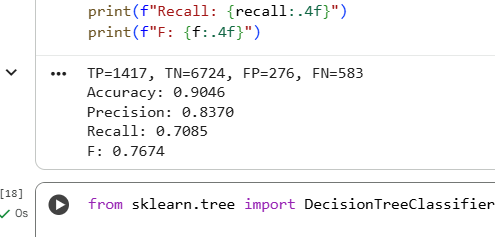

In [ ]:
from sklearn.tree import DecisionTreeClassifier

sklearn_tree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=10,
    random_state=42
)
sklearn_tree.fit(X_train.values, y_train.values)

y_pred = sklearn_tree.predict(X_test.values)
accuracy = accuracy_score(y_test, y_pred)
print(f"Sklearn Tree Accuracy: {accuracy:.4f}")

Sklearn Tree Accuracy: 0.9109
